In [1]:
import pandas as pd
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt

<h3>Importação dos Dados</h3>

In [2]:
source_file = '../../Data/process/patio1_17a19_concilia.csv'
df = pd.read_csv(source_file, delimiter=';', index_col=0, parse_dates=['Data'])
df.head(2)

,Longitude,Latitude,Data,Vento,Pressao,Temperatura,DirecaoVento
0,-42.75,-14.25,2017-01-01 00:00:00,9.815,882.334,22.192,119.15
1,-42.75,-14.25,2017-01-01 01:00:00,8.735,882.333,18.516,119.20


<h3>Manter apenas o Vento e a Data no Dataframe</h3>

In [ ]:
df = df.drop(['Longitude', 'Latitude','Pressao','Temperatura','DirecaoVento'], axis=1)

output_file = '../../Data/process/LMTS.csv'
df.to_csv(output_file, sep=';', encoding='utf-8')

<h3>Função para Geração do Grafico da Serie Temporal</h3>

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

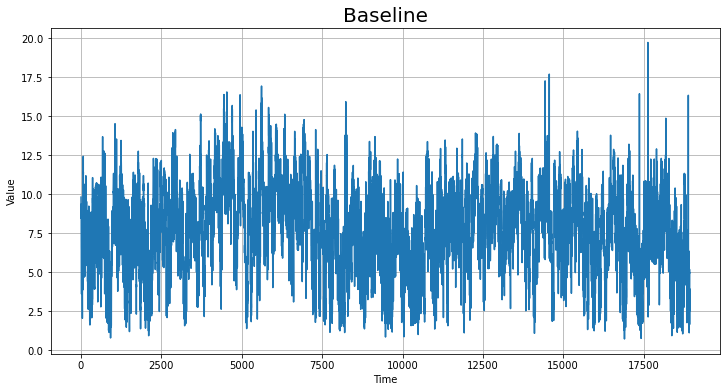

In [19]:
time_step = []
temps = []

with open(output_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[2]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)

plt.figure(figsize=(12, 6))
plt.title('Baseline', fontsize=20)
plot_series(time, series)

In [8]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 22s 348ms/step - loss: 18.4828 - mae: 18.9764
Epoch 2/100
10/10 [==============================] - 5s 370ms/step - loss: 17.9866 - mae: 18.4800
Epoch 3/100
10/10 [==============================] - 3s 219ms/step - loss: 16.8467 - mae: 17.3406
Epoch 4/100
10/10 [==============================] - 2s 210ms/step - loss: 15.6513 - mae: 16.1455
Epoch 5/100
10/10 [==============================] - 3s 232ms/step - loss: 14.2607 - mae: 14.7530
Epoch 6/100
10/10 [==============================] - 3s 237ms/step - loss: 12.6452 - mae: 13.1368
Epoch 7/100
10/10 [==============================] - 3s 239ms/step - loss: 11.0967 - mae: 11.5877
Epoch 8/100
10/10 [==============================] - 3s 251ms/step - loss: 9.4233 - mae: 9.9129
Epoch 9/100
10/10 [==============================] - 3s 231ms/step - loss: 7.9245 - mae: 8.4139
Epoch 10/100
10/10 

(1e-08, 0.0001, 0.0, 60.0)

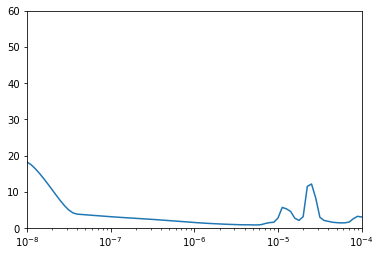

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 16s 191ms/step - loss: 15.9374 - mae: 16.4306
Epoch 2/150
25/25 [==============================] - 7s 248ms/step - loss: 2.5089 - mae: 2.9804
Epoch 3/150
25/25 [==============================] - 6s 222ms/step - loss: 2.2102 - mae: 2.6822
Epoch 4/150
25/25 [==============================] - 6s 225ms/step - loss: 2.1620 - mae: 2.6381
Epoch 5/150
25/25 [==============================] - 6s 224ms/step - loss: 1.9827 - mae: 2.4555
Epoch 6/150
25/25 [==============================] - 5s 186ms/step - loss: 1.9450 - mae: 2.4191
Epoch 7/150
25/25 [==============================] - 5s 175ms/step - loss: 1.7151 - mae: 2.1829 1s - loss: 1.7336 - mae
Epoch 8/150
25/25 [==============================] - 5s 177ms/step - loss: 1.6221 - mae: 2.0876 3s - loss
Epoch 9/150
25/25 [==============================] - 4s 164ms/step - loss: 1.5817 - mae: 2.0465
Epoch 10/150
25/25 [==============================] - 4s 163ms/step - loss: 1.5646 - mae: 2.0301
Ep

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

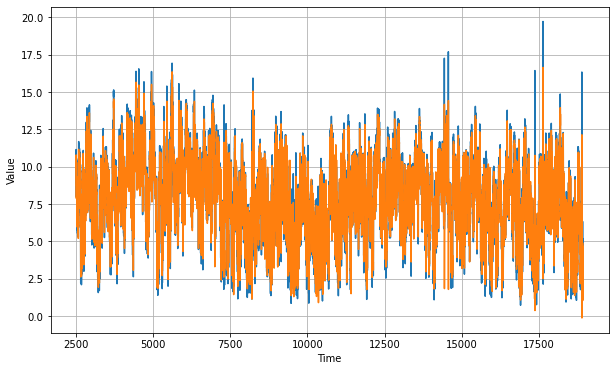

In [15]:
# original data (blue) vs forecasted values (orange)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [21]:
tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()


0.9033608

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.69472533

In [17]:
print(rnn_forecast)

[10.173761  10.152843  10.226109  ...  2.5118186  3.5381465  2.699098 ]
